In [1]:
import numpy as np

# if seaborn is not yet installed, run `pip install seaborn` in terminal
import seaborn as sns
from sklearn.base import BaseEstimator
from sklearn.datasets import (
    load_boston,
    load_digits,
    make_classification,
    make_regression,
)
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

sns.set()
import matplotlib.pyplot as plt

# sharper plots
%config InlineBackend.figure_format = 'retina'

In [2]:
RANDOM_STATE = 17

In [3]:
# Let's define quality criterion:
# entropy and Gini criteria are used for classification
def entropy(y):
    p = [len(y[y == k]) / len(y) for k in np.unique(y)]
    return -np.dot(p, np.log2(p))


def gini(y):
    p = [len(y[y == k]) / len(y) for k in np.unique(y)]
    return 1 - np.dot(p, p)


# variance and median criteria are used for regression
def variance(y):
    return np.var(y)


def mad_median(y):
    return np.mean(np.abs(y - np.median(y)))


criteria_dict = {
    "entropy": entropy,
    "gini": gini,
    "variance": variance,
    "mad_median": mad_median,
}

In [4]:
class Node:
    def __init__(self, feature_idx=0, threshold=0, labels=None, left=None, right=None):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.labels = labels
        self.left = left
        self.right = right

In [5]:
def regression_leaf(y):
    return np.mean(y)


def classification_leaf(y):
    return np.bincount(y).argmax()

In [6]:
class DecisionTree(BaseEstimator):
    def __init__(
        self, max_depth=np.inf, min_samples_split=2, criterion="gini", debug=False,
    ):
        # Set parameters
        params = {
            "max_depth": max_depth,
            "min_samples_split": min_samples_split,
            "criterion": criterion,
            "debug": debug,
        }

        for param_name, param_value in params.items():
            setattr(self, param_name, param_value)

        super(DecisionTree, self).set_params(**params)

        self._criterion_function = criteria_dict[criterion]

        if criterion in ["variance", "mad_median"]:
            self._leaf_value = regression_leaf
        else:
            self._leaf_value = classification_leaf

        if self.debug:
            print(f"\nDecisionTree params:\n{params}")

    # Functional for splitting the data by two parts
    def _functional(self, X, y, feature_idx, threshold):
        mask = X[:, feature_idx] < threshold
        n_obj = X.shape[0]
        n_left = np.sum(mask)
        n_right = n_obj - n_left
        if n_left > 0 and n_right > 0:
            return (
                self._criterion_function(y)
                - (n_left / n_obj) * self._criterion_function(y[mask])
                - (n_right / n_obj) * self._criterion_function(y[~mask])
            )
        else:
            return 0

    # Recursive procedure for building decision tree
    def _build_tree(self, X, y, depth=1):
        max_functional = 0
        best_feature_idx = None
        best_threshold = None
        n_samples, n_features = X.shape

        # If all objects in a current vertex have the same values in answers
        # then the value of the functional will be 0 for all partitions.
        # So in this case the vertex is a leaf. In order not to make unnecessary calculations,
        # perform this check before the main cycle.
        if len(np.unique(y)) == 1:
            return Node(labels=y)

        # If the stop criterion is not satisfied, search for the optimal partition
        if depth < self.max_depth and n_samples >= self.min_samples_split:
            if self.debug:
                print("depth = {}, n_samples = {}".format(depth, n_samples))

            # Iterate for all features...
            for feature_idx in range(n_features):
                # and all thresholds for fixed feature
                threshold_values = np.unique(X[:, feature_idx])
                functional_values = [
                    self._functional(X, y, feature_idx, threshold)
                    for threshold in threshold_values
                ]

                best_threshold_idx = np.nanargmax(functional_values)

                if functional_values[best_threshold_idx] > max_functional:
                    max_functional = functional_values[best_threshold_idx]
                    best_threshold = threshold_values[best_threshold_idx]
                    best_feature_idx = feature_idx
                    best_mask = X[:, feature_idx] < best_threshold

        if best_feature_idx is not None:
            if self.debug:
                print(
                    "best feature = {}, best threshold = {}".format(
                        best_feature_idx, best_threshold
                    )
                )
            # In case of partition go next recursivelly...
            return Node(
                feature_idx=best_feature_idx,
                threshold=best_threshold,
                left=self._build_tree(X[best_mask, :], y[best_mask], depth + 1),
                right=self._build_tree(X[~best_mask, :], y[~best_mask], depth + 1),
            )
        else:
            # else the vertex is a leaf, leave recursion
            return Node(labels=y)

    def fit(self, X, y):
        # In classification task memorize the number of classes
        if self.criterion in ["gini", "entropy"]:
            self._n_classes = len(np.unique(y))

        self.root = self._build_tree(X, y)

        return self

    # Predict the answer for single object
    def _predict_object(self, x, node=None):

        node = self.root
        # Traverse from root to the leaf
        while node.labels is None:
            if x[node.feature_idx] < node.threshold:
                node = node.left
            else:
                node = node.right
        # Calculate the answer
        return self._leaf_value(node.labels)

    def predict(self, X):
        return np.array([self._predict_object(x) for x in X])

    def _predict_proba_object(self, x, node=None):

        node = self.root
        # Traverse from root to the leaf
        while node.labels is None:
            if x[node.feature_idx] < node.threshold:
                node = node.left
            else:
                node = node.right
        # Compute probabilities of classes
        return [
            len(node.labels[node.labels == k]) / len(node.labels)
            for k in range(self._n_classes)
        ]

    def predict_proba(self, X):
        return np.array([self._predict_proba_object(x) for x in X])

Accuracy: 0.85
predict_proba works!


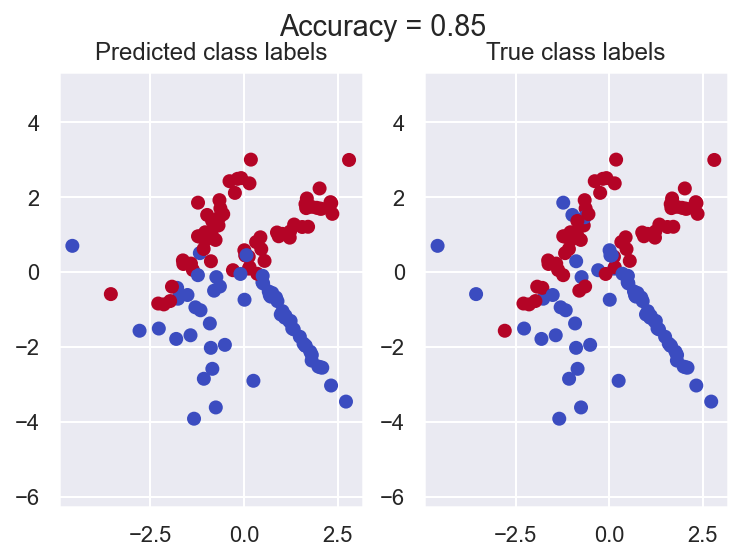

In [7]:
X, y = make_classification(
    n_features=2, n_redundant=0, n_samples=400, random_state=RANDOM_STATE
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE
)

clf = DecisionTree(max_depth=4, criterion="gini")
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
prob_pred = clf.predict_proba(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

if sum(np.argmax(prob_pred, axis=1) - y_pred) == 0:
    print("predict_proba works!")

plt.suptitle("Accuracy = {:.2f}".format(accuracy))
plt.subplot(121)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap=plt.cm.coolwarm)
plt.title("Predicted class labels")
plt.axis("equal")
plt.subplot(122)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm)
plt.title("True class labels")
plt.axis("equal");

In [8]:
digits = load_digits()

X = digits.data
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

clf1 = DecisionTree(max_depth=2, criterion="gini", debug=True)
clf1.fit(X_train, y_train)

print(accuracy_score(clf1.predict(X_test), y_test))


clf2 = DecisionTree(max_depth=2, criterion="entropy", debug=True)
clf2.fit(X_train, y_train)

print(accuracy_score(clf2.predict(X_test), y_test))


DecisionTree params:
{'max_depth': 2, 'min_samples_split': 2, 'criterion': 'gini', 'debug': True}
depth = 1, n_samples = 1437


best feature = 36, best threshold = 1.0
0.18888888888888888

DecisionTree params:
{'max_depth': 2, 'min_samples_split': 2, 'criterion': 'entropy', 'debug': True}
depth = 1, n_samples = 1437


best feature = 21, best threshold = 2.0
0.175


In [9]:
%%time
tree_params = {"max_depth": list(range(3, 11))}

grid_clf_crit_gini = GridSearchCV(
    estimator=DecisionTree(criterion="gini"),
    param_grid=tree_params,
    cv=5,
    scoring="accuracy",
    n_jobs=4,
)

grid_clf_crit_gini.fit(X_train, y_train)

print(grid_clf_crit_gini.best_score_, grid_clf_crit_gini.best_params_)

0.8434306039488966 {'max_depth': 10}
CPU times: user 5.69 s, sys: 117 ms, total: 5.81 s
Wall time: 33.9 s


In [10]:
grid_clf_crit_entropy = GridSearchCV(
    estimator=DecisionTree(criterion="entropy"),
    param_grid=tree_params,
    cv=5,
    scoring="accuracy",
    n_jobs=4,
)

grid_clf_crit_entropy.fit(X_train, y_train)

print(grid_clf_crit_entropy.best_score_, grid_clf_crit_entropy.best_params_)

0.8629186024003097 {'max_depth': 9}


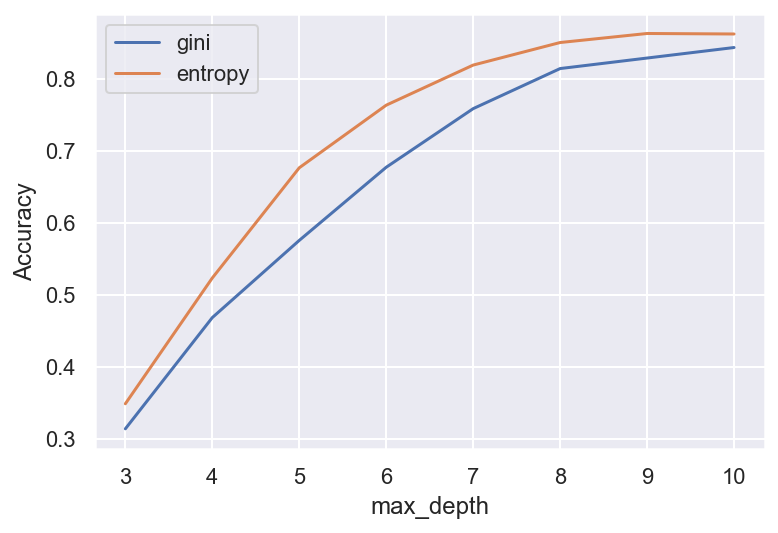

In [11]:
scores_for_crit_gini = np.array(grid_clf_crit_gini.cv_results_["mean_test_score"])
scores_for_crit_entropy = np.array(grid_clf_crit_entropy.cv_results_["mean_test_score"])

plt.plot(tree_params["max_depth"], scores_for_crit_gini, label="gini")
plt.plot(tree_params["max_depth"], scores_for_crit_entropy, label="entropy")
plt.legend(loc="best")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.show();

In [12]:
clf = DecisionTree(max_depth=9, criterion="entropy")
clf.fit(X_train, y_train)
probs = clf.predict_proba(X_test)

In [13]:
mean_probs = np.mean(probs, axis=0)
print(mean_probs, max(mean_probs))

[0.09166667 0.07700282 0.09854938 0.08930086 0.12690476 0.11898148
 0.08194444 0.09805556 0.10465062 0.11294341] 0.12690476190476194


In [14]:
X, y = make_regression(
    n_features=1, n_samples=200, bias=0, noise=5, random_state=RANDOM_STATE
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

reg = DecisionTree(max_depth=6, criterion="mad_median")
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

plt.scatter(X_test[:, 0], y_test, color="black")
plt.scatter(X_test[:, 0], y_pred, color="green")
plt.title("MSE = {:.2f}".format(mse));

Mean Squared Error: 58.34123567302283


In [15]:
boston = load_boston()

X = boston.data
y = boston.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

clf1 = DecisionTree(max_depth=2, criterion="variance", debug=True)
clf1.fit(X_train, y_train)

print(mean_squared_error(clf1.predict(X_test), y_test))


clf2 = DecisionTree(max_depth=2, criterion="mad_median", debug=True)
clf2.fit(X_train, y_train)

print(mean_squared_error(clf2.predict(X_test), y_test))

/Users/kashnitskiyy/opt/anaconda3/envs/mlcourse/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include


DecisionTree params:
{'max_depth': 2, 'min_samples_split': 2, 'criterion': 'variance', 'debug': True}
depth = 1, n_samples = 404


best feature = 12, best threshold = 7.51
54.63221936139991

DecisionTree params:
{'max_depth': 2, 'min_samples_split': 2, 'criterion': 'mad_median', 'debug': True}
depth = 1, n_samples = 404


best feature = 5, best threshold = 6.8
40.82003832415897


In [16]:
%%time
tree_params = {"max_depth": list(range(2, 9))}

grid_reg_crit_mad_median = GridSearchCV(
    estimator=DecisionTree(criterion="mad_median"),
    param_grid=tree_params,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=8,
)

grid_reg_crit_mad_median.fit(X_train, y_train)

CPU times: user 2.51 s, sys: 95.1 ms, total: 2.6 s
Wall time: 19.2 s


GridSearchCV(cv=5, estimator=DecisionTree(criterion='mad_median'), n_jobs=8,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8]},
             scoring='neg_mean_squared_error')

In [17]:
grid_reg_crit_variance = GridSearchCV(
    estimator=DecisionTree(criterion="variance"),
    param_grid=tree_params,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=8,
)

grid_reg_crit_variance.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTree(criterion='variance'), n_jobs=8,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8]},
             scoring='neg_mean_squared_error')

In [18]:
scores_for_crit_mad_median = -np.array(
    grid_reg_crit_mad_median.cv_results_["mean_test_score"]
)
scores_for_crit_variance = -np.array(
    grid_reg_crit_variance.cv_results_["mean_test_score"]
)

plt.plot(tree_params["max_depth"], scores_for_crit_mad_median, label="mad_median")
plt.plot(tree_params["max_depth"], scores_for_crit_variance, label="variance")
plt.legend()
plt.xlabel("max_depth")
plt.ylabel("MSE")
plt.show();

In [19]:
print("Criterion: mad_median")
print("Best params:", grid_reg_crit_mad_median.best_params_)
print("Best cross validaton MSE:", abs(grid_reg_crit_mad_median.best_score_))

print("Criterion: variance")
print("Best params:", grid_reg_crit_variance.best_params_)
print("Best cross validaton MSE:", abs(grid_reg_crit_variance.best_score_))

Criterion: mad_median
Best params: {'max_depth': 5}
Best cross validaton MSE: 21.157004600133206
Criterion: variance
Best params: {'max_depth': 6}
Best cross validaton MSE: 21.23696740219734
